In [26]:
%pip install pandas -q
%pip install matplotlib -q
%pip install kagglehub -q
%pip install tensorflow -q
%pip install scikit-learn -q
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [28]:
# загрузим данные
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


In [29]:
# преднастройка формаирование датасета
settings_loading_data = dict(
    labels='inferred',
    label_mode='binary',
    color_mode='rgb', # если использовать предобученную ч/б модель, то изменить этот параметр на 'grayscale'
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest', # Попробовать: bicubic (лучшая, но тяжёлая) lanczos3/5 (вроде норм)
    batch_size=BATCH_SIZE,
    seed=RANDOM_SEED
)

In [30]:
# сформируем датасеты
df_train = image_dataset_from_directory(
    path + '/chest_xray/train',
    shuffle=True,
    **settings_loading_data
)

df_valid = image_dataset_from_directory(
    path + '/chest_xray/val',
    shuffle=False,
    **settings_loading_data
)

df_test = image_dataset_from_directory(
    path + '/chest_xray/test',
    shuffle=False,
    **settings_loading_data
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [31]:
# вывод 9 фотографий из датасета для примера
class_names = df_train.class_names
print("Классы:", class_names)

# for images, labels in df_train.take(1):
#     plt.figure(figsize=(10, 10))
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray') 
#         plt.title(f"Class: {class_names[int(labels[i].numpy().item())]}")
#         plt.axis("off")
#     plt.show()

Классы: ['NORMAL', 'PNEUMONIA']


In [32]:
# т.к. 16 изображений валидационной выборки - это очень мало, то объединим test с val, а потом разобьем их
df_train_full = df_train.concatenate(df_valid)
val_size = int(len(df_train_full) * 0.2)

df_valid = df_train_full.take(val_size)
df_train = df_train_full.skip(val_size)

print(f"Новый размер train (батчей): {len(df_train)}")
print(f"Новый размер valid (батчей): {len(df_valid)}")

Новый размер train (батчей): 132
Новый размер valid (батчей): 32


In [33]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1067 изображений
Класс PNEUMONIA (1): 3141 изображений


In [34]:
# настроим аугментацию
# 1. будем поворачивать фотографии, на 10 градусов в разные стороны
# 2. смещаем фотографии по вертикали и горизонатли на 10 процентов
# 3. зумим фотографии на 20 процентов
data_augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=10/360.0, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="nearest", interpolation="bilinear"),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode="nearest", interpolation="bilinear")
])

In [35]:
#применим аугментацию
def augment_and_preprocess_train(image, label):
    image_augmented = data_augmentation_pipeline(image, training=True)

    image_float_0_1 = tf.image.convert_image_dtype(image_augmented, tf.float32)
    brightness_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    image_brightened = image_float_0_1 * brightness_factor
    image_brightened = tf.clip_by_value(image_brightened, 0.0, 1.0)

    image_for_resnet_preprocess = image_brightened * 255.0
    image_preprocessed = preprocess_input(image_for_resnet_preprocess) 

    return image_preprocessed, label

def preprocess_val_test(image, label):
    image = tf.cast(image, tf.float32) # Просто переводим в float32
    image_preprocessed = preprocess_input(image) # И применяем ту же предобработку ResNet
    return image_preprocessed, label


df_train_processed = df_train.map(augment_and_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_test_processed = df_test.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
df_valid_processed = df_valid.map(preprocess_val_test, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# создадим модель
tf.keras.backend.set_image_data_format('channels_last')
backbone = ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)


model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=2e-4) 
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[
        'accuracy',       
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [37]:
# проверим баланс классов
# TODO - сделать попроще это ячейку
labels = []
for _, label_batch in df_train_processed:
    labels.extend(label_batch.numpy())

normal_count = np.sum(np.array(labels) == 0)
pneumonia_count = np.sum(np.array(labels) == 1)

print(f"Класс NORMAL (0): {normal_count} изображений")
print(f"Класс PNEUMONIA (1): {pneumonia_count} изображений")

Класс NORMAL (0): 1077 изображений
Класс PNEUMONIA (1): 3131 изображений


2025-06-30 12:25:37.716716: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
# рассчитаем class_weights
# сделаем это через кол-во элементов одного и второго класса
labels = np.concatenate([y for x, y in df_train_processed], axis=0)
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)
total_count = len(labels)

weight_for_0 = (1 / normal_count) * (total_count / 2)
weight_for_1 = (1 / pneumonia_count) * (total_count / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

In [14]:
# используем коллбэки
# 1. Настройка learning rate при обучении
# 2. Сохранение лучшей версии модели
# 3. Остановка обучения, если нет улучшений
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    df_train_processed,
    validation_data=df_valid_processed,
    class_weight=class_weights,
    epochs=10,
    callbacks=[reduce_lr, model_checkpoint, early_stopping]
)

Epoch 1/10


I0000 00:00:1751268599.848719   12369 service.cc:152] XLA service 0x72e8e40388e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751268599.848755   12369 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-06-30 10:30:01.050397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751268603.902387   12369 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751268622.022025   12369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7833 - auc: 0.8276 - loss: 0.5396 - precision: 0.8997 - recall: 0.7987

132/132 ━━━━━━━━━━━━━━━━━━━━ 88s 366ms/step - accuracy: 0.7834 - auc: 0.8278 - loss: 0.5394 - precision: 0.8998 - recall: 0.7989 - val_accuracy: 0.2920 - val_auc: 0.5465 - val_loss: 0.8041 - val_precision: 0.8276 - val_recall: 0.0323 - learning_rate: 2.0000e-04
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 194ms/step - accuracy: 0.8273 - auc: 0.8851 - loss: 0.4409 - precision: 0.9376 - recall: 0.8222 - val_accuracy: 0.2764 - val_auc: 0.5024 - val_loss: 1.1139 - val_precision: 1.0000 - val_recall: 0.0172 - learning_rate: 2.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8343 - auc: 0.8925 - loss: 0.4294 - precision: 0.9422 - recall: 0.8221
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.8343 - auc: 0.8926 - loss: 0.4292 - precision: 0.9422 - recall: 0.8222 - val_accuracy: 0.3008 - val_auc: 0.8107 - val_loss: 1.6671 - val_precision: 1.0000 - val_recall: 0.0402 - learning_rate

132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 202ms/step - accuracy: 0.8659 - auc: 0.9299 - loss: 0.3332 - precision: 0.9580 - recall: 0.8587 - val_accuracy: 0.4346 - val_auc: 0.3315 - val_loss: 0.7707 - val_precision: 0.6353 - val_recall: 0.5182 - learning_rate: 4.0000e-05
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8675 - auc: 0.9328 - loss: 0.3215 - precision: 0.9576 - recall: 0.8601

132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 203ms/step - accuracy: 0.8674 - auc: 0.9328 - loss: 0.3216 - precision: 0.9576 - recall: 0.8601 - val_accuracy: 0.6895 - val_auc: 0.4353 - val_loss: 0.6567 - val_precision: 0.7212 - val_recall: 0.9342 - learning_rate: 4.0000e-05
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8615 - auc: 0.9233 - loss: 0.3436 - precision: 0.9578 - recall: 0.8513

132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 204ms/step - accuracy: 0.8615 - auc: 0.9233 - loss: 0.3435 - precision: 0.9578 - recall: 0.8514 - val_accuracy: 0.7236 - val_auc: 0.4925 - val_loss: 0.6480 - val_precision: 0.7273 - val_recall: 0.9906 - learning_rate: 4.0000e-05
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8583 - auc: 0.9331 - loss: 0.3330 - precision: 0.9554 - recall: 0.8456

132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 206ms/step - accuracy: 0.8583 - auc: 0.9330 - loss: 0.3331 - precision: 0.9554 - recall: 0.8456 - val_accuracy: 0.7168 - val_auc: 0.6090 - val_loss: 0.5923 - val_precision: 0.7315 - val_recall: 0.9665 - learning_rate: 4.0000e-05
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 198ms/step - accuracy: 0.8693 - auc: 0.9338 - loss: 0.3226 - precision: 0.9590 - recall: 0.8605 - val_accuracy: 0.7197 - val_auc: 0.3287 - val_loss: 0.8023 - val_precision: 0.7267 - val_recall: 0.9852 - learning_rate: 4.0000e-05
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8698 - auc: 0.9354 - loss: 0.3149 - precision: 0.9624 - recall: 0.8586
Epoch 10: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 197ms/step - accuracy: 0.8697 - auc: 0.9354 - loss: 0.3150 - precision: 0.9623 - recall: 0.8586 - val_accuracy: 0.7236 - val_auc: 0.2570 - val_loss: 1.2708 - val_precision: 0.7234 - val_recall: 1.0000 - learning_rat

In [15]:
# проверим модель на тесте
results = model.evaluate(df_test_processed)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.3457 - auc: 0.4773 - loss: 1.0327 - precision: 0.3038 - recall: 0.6598
Test Loss: 0.6858784556388855
Test Accuracy: 0.6330128312110901


___
    ДО class_weights:
    Test Loss: 0.6504877805709839
    Test Accuracy: 0.6089743375778198

    ПОСЛЕ class_weights:
    Test Loss: 0.6858784556388855
    Test Accuracy: 0.6330128312110901
___

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


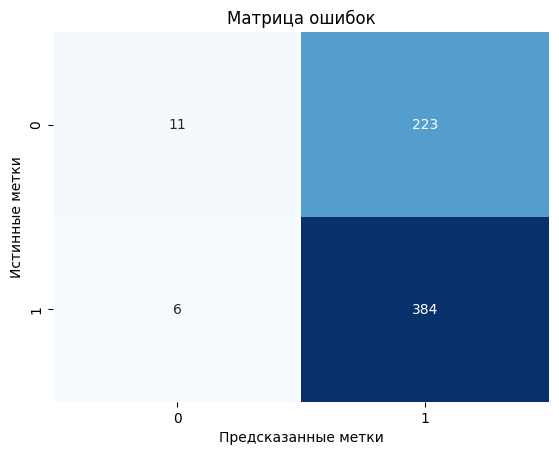

In [17]:
# сделаем матрицу ошибок
y_pred_proba = model.predict(df_test_processed)
y_pred = (y_pred_proba > 0.5).astype('int32')
y_true = np.concatenate([y for x, y in df_test_processed], axis=0)


cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

___
  ДО class_weights:
  0 - 17 - 217
  1 - 27 - 363
    | 0  |  1 |

  ПОСЛЕ class_weights:
  0 - 11 - 223
  1 - 6 - 384
    | 0  |  1 |
___